# Hospital Readmission Risk Prediction

## Step 1: Load and Explore Datasets


In [32]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
import shap

# 2. Load Datasets
# Paths to the datasets
data_paths = {
    "patients": r"C:\Users\Akshay\OneDrive\Documents\Dissertation_Report\synthea-master\output\csv\2024_12_09T02_39_10Z\patients.csv",
    "encounters": r"C:\Users\Akshay\OneDrive\Documents\Dissertation_Report\synthea-master\output\csv\2024_12_09T02_39_10Z\encounters.csv",
    "conditions": r"C:\Users\Akshay\OneDrive\Documents\Dissertation_Report\synthea-master\output\csv\2024_12_09T02_39_10Z\conditions.csv",
    "medications": r"C:\Users\Akshay\OneDrive\Documents\Dissertation_Report\synthea-master\output\csv\2024_12_09T02_39_10Z\medications.csv",
    "observations": r"C:\Users\Akshay\OneDrive\Documents\Dissertation_Report\synthea-master\output\csv\2024_12_09T02_39_10Z\observations.csv"
}

# Log: Paths loaded
print("Dataset paths loaded successfully.")

# Load the datasets
data = {}
for name, path in data_paths.items():
    try:
        data[name] = pd.read_csv(path)
        print(f"{name.capitalize()} dataset loaded successfully. Shape: {data[name].shape}")
    except Exception as e:
        print(f"Error loading {name} dataset: {e}")

# Display summaries of the datasets
for name, df in data.items():
    print(f"\n{name.capitalize()} dataset shape: {df.shape}")
    print(df.head(), "\n")

## Step 2: Merge Core Datasets (Patients and Encounters)
# Rename 'ID' in Patients dataset to 'PATIENT'
df_patients = data['patients']
df_encounters = data['encounters']
df_patients.rename(columns={'ID': 'PATIENT'}, inplace=True)


# Verify renaming
print("Columns in Patients dataset before renaming:", df_patients.columns)
# Correctly rename 'Id' to 'PATIENT'
df_patients.rename(columns={'Id': 'PATIENT'}, inplace=True)

# Verify the renaming
print("Columns in Patients dataset after renaming:", df_patients.columns)
print("Columns in Patients dataset after renaming:", df_patients.columns)

# Standardize column data types
df_encounters['PATIENT'] = df_encounters['PATIENT'].astype(str)
df_patients['PATIENT'] = df_patients['PATIENT'].astype(str)

# Merge datasets
try:
    df_merged = pd.merge(df_encounters, df_patients, on='PATIENT', how='inner')
    print("Datasets merged successfully. Shape:", df_merged.shape)
except Exception as e:
    print("Error during merging:", e)

# Save the merged dataset for verification
try:
    output_path = r"C:\Users\Akshay\OneDrive\Documents\Dissertation_Report\synthea-master\output\csv\merged_patients_encounters.csv"
    df_merged.to_csv(output_path, index=False)
    print(f"Merged dataset saved successfully at {output_path}")
except Exception as e:
    print("Error saving merged dataset:", e)

# Display the shape and columns of the merged dataset
print(f"\nMerged dataset columns: {df_merged.columns}")

# Save the merged dataset
df_merged.to_csv("merged_dataset.csv", index=False)
print("Merged dataset saved as 'merged_dataset.csv'.")
print(df_merged.head())
print("Columns in merged dataset:", df_merged.columns)

Dataset paths loaded successfully.
Patients dataset loaded successfully. Shape: (5000, 28)
Encounters dataset loaded successfully. Shape: (167766, 15)
Conditions dataset loaded successfully. Shape: (117691, 7)
Medications dataset loaded successfully. Shape: (135662, 13)
Observations dataset loaded successfully. Shape: (1997232, 9)

Patients dataset shape: (5000, 28)
                                     Id   BIRTHDATE  DEATHDATE          SSN  \
0  146ef16d-39bd-82a3-f6fa-83bbd95d2c40  2018-08-15        NaN  999-69-9400   
1  5d1e5a7a-834b-42d2-f7a2-9931da8e6336  1981-07-24        NaN  999-55-6164   
2  f5d12054-ee9c-3738-829a-9aaa6375e84f  1999-03-10        NaN  999-87-4945   
3  609b8f3d-3353-8c1e-10f6-75f5ad911e7d  1998-05-29        NaN  999-57-7246   
4  4d228fb7-8d07-02e6-5c63-aee8e553be97  1958-03-31        NaN  999-87-9744   

     DRIVERS    PASSPORT PREFIX         FIRST        MIDDLE         LAST  ...  \
0        NaN         NaN    NaN     Yelena240      Kasha638      Yost751  .

## Step 3: Exploratory Data Analysis (EDA)

### Basic Information

In [33]:
# 1. Basic Information
print("Dataset Shape:", df_merged.shape)
print("Dataset Info:")
print(df_merged.info())

# 2. Summary Statistics
print("\nSummary Statistics:")
print(df_merged.describe())

# 3. Check Missing Values
print("\nMissing Values per Column:")
print(df_merged.isnull().sum())

Dataset Shape: (167766, 42)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167766 entries, 0 to 167765
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Id                   167766 non-null  object 
 1   START                167766 non-null  object 
 2   STOP                 167766 non-null  object 
 3   PATIENT              167766 non-null  object 
 4   ORGANIZATION         167766 non-null  object 
 5   PROVIDER             167766 non-null  object 
 6   PAYER                167766 non-null  object 
 7   ENCOUNTERCLASS       167766 non-null  object 
 8   CODE                 167766 non-null  int64  
 9   DESCRIPTION          167766 non-null  object 
 10  BASE_ENCOUNTER_COST  167766 non-null  float64
 11  TOTAL_CLAIM_COST     167766 non-null  float64
 12  PAYER_COVERAGE       167766 non-null  float64
 13  REASONCODE           96518 non-null   float64
 14  REASONDESCRIPTION    96518

### Visualize Distributions


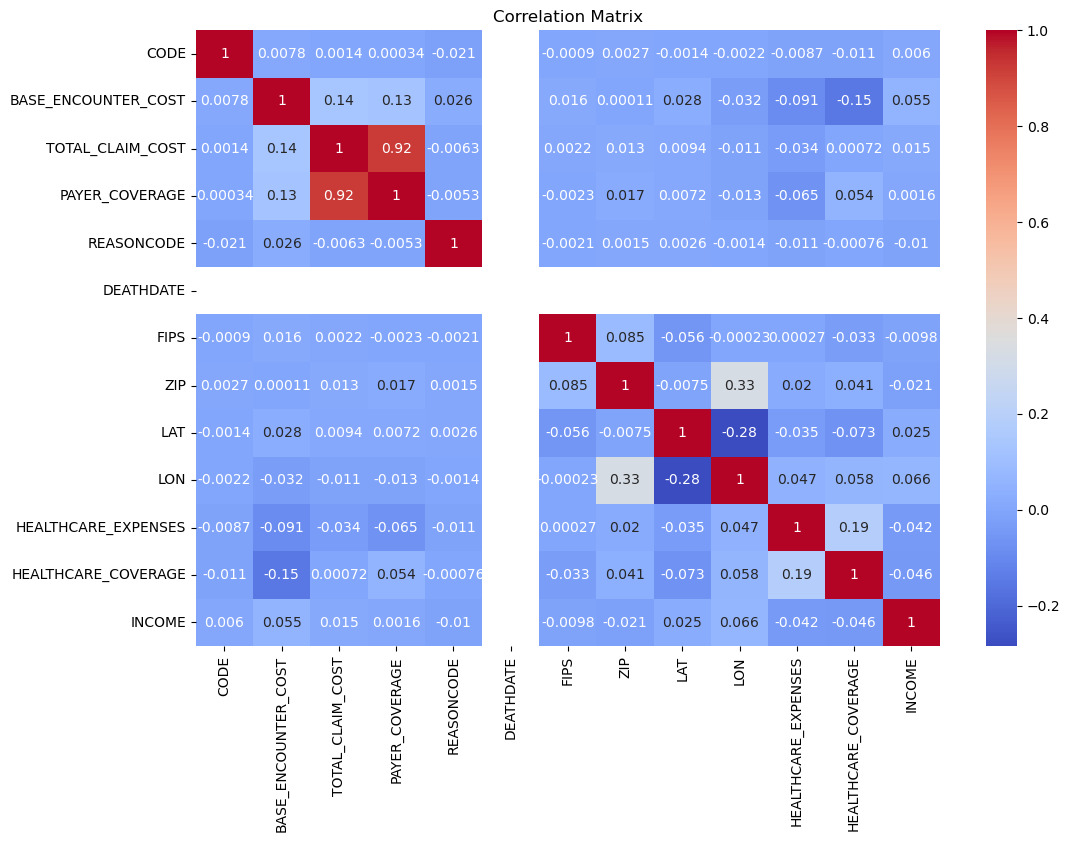

In [41]:
# Age Distribution
if 'AGE' in df_merged.columns:
    sns.histplot(df_merged['AGE'], bins=20, kde=True)
    plt.title("Age Distribution")
    plt.show()

# Class Distribution (if target variable exists)
if 'READMISSION' in df_merged.columns:
    sns.countplot(x='READMISSION', data=df_merged)
    plt.title("Class Distribution (Readmission)")
    plt.show()

# Correlation Heatmap
# Select only numeric columns
numeric_df = df_merged.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


## Step 4:  Handling Missing Values

In [42]:
# 1. Check Missing Values
print("Missing Values per Column (Before Handling):")
print(df_merged.isnull().sum())

# 2. Handle Missing Values
# Numeric columns: Impute with median
numeric_columns = df_merged.select_dtypes(include=[np.number]).columns
for column in numeric_columns:
    if df_merged[column].isnull().sum() > 0:
        df_merged[column].fillna(df_merged[column].median(), inplace=True)

# Categorical columns: Impute with mode
categorical_columns = df_merged.select_dtypes(include=['object']).columns
for column in categorical_columns:
    if df_merged[column].isnull().sum() > 0:
        df_merged[column].fillna(df_merged[column].mode()[0], inplace=True)

# 3. Verify Missing Values are Handled
print("\nMissing Values per Column (After Handling):")
print(df_merged.isnull().sum())

Missing Values per Column (Before Handling):
Id                          0
START                       0
STOP                        0
PATIENT                     0
ORGANIZATION                0
PROVIDER                    0
PAYER                       0
ENCOUNTERCLASS              0
CODE                        0
DESCRIPTION                 0
BASE_ENCOUNTER_COST         0
TOTAL_CLAIM_COST            0
PAYER_COVERAGE              0
REASONCODE              71248
REASONDESCRIPTION       71248
BIRTHDATE                   0
DEATHDATE              167766
SSN                         0
DRIVERS                 13372
PASSPORT                20871
PREFIX                  16797
FIRST                       0
MIDDLE                  32391
LAST                        0
SUFFIX                 165544
MAIDEN                 112010
MARITAL                 33472
RACE                        0
ETHNICITY                   0
GENDER                      0
BIRTHPLACE                  0
ADDRESS                  

## Step 5: Feature Engineering and Target Variable Creation

### Feature Engineering


In [43]:
# Calculate Age from Birthdate
df_merged['AGE'] = pd.to_datetime('today').year - pd.to_datetime(df_merged['BIRTHDATE']).dt.year

# Normalize healthcare expenses to coverage ratio
df_merged['EXPENSE_COVERAGE_RATIO'] = df_merged['HEALTHCARE_EXPENSES'] / (df_merged['HEALTHCARE_COVERAGE'] + 1)

# Aggregate total and average costs
df_merged['TOTAL_COST_RATIO'] = df_merged['TOTAL_CLAIM_COST'] / (df_merged['BASE_ENCOUNTER_COST'] + 1)

### Define Target Variable

In [44]:
# Define READMISSION
# Ensure START and STOP are datetime objects
df_merged['START'] = pd.to_datetime(df_merged['START'])
df_merged['STOP'] = pd.to_datetime(df_merged['STOP'])

# Identify readmissions within 30 days
df_merged['READMISSION'] = df_merged.groupby('PATIENT')['START'].diff().dt.days.between(1, 30).astype(int)
df_merged['READMISSION'].fillna(0, inplace=True)  # Fill first encounters as no readmission

### Verify Changes

In [46]:
# Check the first few rows to verify the new features
print(df_merged[['AGE', 'EXPENSE_COVERAGE_RATIO', 'TOTAL_COST_RATIO', 'READMISSION']].head())

#Verify the Target Variable:
print("READMISSION Value Counts:")
print(df_merged['READMISSION'].value_counts())

#Save modified data for future use
df_merged.to_csv("updated_dataset.csv", index=False)
print("Updated dataset saved as 'updated_dataset.csv'.")

   AGE  EXPENSE_COVERAGE_RATIO  TOTAL_COST_RATIO  READMISSION
0    6                22213.76          5.927431            0
1    6                22213.76          3.544993            0
2    6                22213.76          3.544993            0
3    6                22213.76          3.544993            0
4    6                22213.76          0.988446            0
READMISSION Value Counts:
READMISSION
1    88309
0    79457
Name: count, dtype: int64
Updated dataset saved as 'updated_dataset.csv'.


## Step 6: Data Preprocessing


### Handle Class Imbalance



In [52]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_columns = X_cleaned.select_dtypes(include=['object']).columns
print("Categorical columns to encode:", categorical_columns)

# Apply Label Encoding to convert strings to numeric values
label_encoder = LabelEncoder()
for col in categorical_columns:
    X_cleaned[col] = label_encoder.fit_transform(X_cleaned[col])

# Verify all columns are now numeric
print("Data types in X_cleaned after encoding:")
print(X_cleaned.dtypes)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_cleaned, y)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

Categorical columns to encode: Index(['ENCOUNTERCLASS', 'REASONDESCRIPTION', 'SSN', 'DRIVERS', 'PASSPORT',
       'PREFIX', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER',
       'BIRTHPLACE', 'COUNTY'],
      dtype='object')
Data types in X_cleaned after encoding:
ENCOUNTERCLASS              int32
CODE                        int64
BASE_ENCOUNTER_COST       float64
TOTAL_CLAIM_COST          float64
PAYER_COVERAGE            float64
REASONCODE                float64
REASONDESCRIPTION           int32
SSN                         int32
DRIVERS                     int32
PASSPORT                    int32
PREFIX                      int32
SUFFIX                      int32
MAIDEN                      int32
MARITAL                     int32
RACE                        int32
ETHNICITY                   int32
GENDER                      int32
BIRTHPLACE                  int32
COUNTY                      int32
FIPS                      float64
LAT                       float64
LON   

### Encode Categorical Variables



In [53]:
# One-hot encoding for categorical variables
X_encoded = pd.get_dummies(X_resampled, columns=categorical_columns, drop_first=True)

# Verify encoding
print("Encoded feature shape:", X_encoded.shape)

Encoded feature shape: (176618, 13905)


#### High-Cardinality Handling

In [64]:
# Check unique value counts in categorical columns
high_cardinality_threshold = 50  # Adjust based on your dataset
high_cardinality_cols = [col for col in categorical_columns if X_resampled[col].nunique() > high_cardinality_threshold]

print("High-cardinality columns to exclude:", high_cardinality_cols)

# Drop high-cardinality columns before encoding
X_resampled = X_resampled.drop(columns=high_cardinality_cols, errors='ignore')

# Apply One-Hot Encoding again
X_encoded = pd.get_dummies(X_resampled, drop_first=True)

print("Encoded feature shape after excluding high-cardinality columns:", X_encoded.shape)

Encoded feature shape after excluding high-cardinality columns: (176618, 22)


### Scale Numeric Features

In [65]:
from sklearn.preprocessing import StandardScaler

# Apply standard scaling
scaler = StandardScaler()
numeric_columns = X_encoded.select_dtypes(include=[np.number]).columns
X_encoded[numeric_columns] = scaler.fit_transform(X_encoded[numeric_columns])

# Verify scaling
print("Scaled numeric features:")
print(X_encoded[numeric_columns].head())

Scaled numeric features:
   ENCOUNTERCLASS      CODE  BASE_ENCOUNTER_COST  TOTAL_CLAIM_COST  \
0        1.406562 -0.018720             0.830825         -0.277173   
1        1.406562 -0.018720             0.830825         -0.336563   
2        1.406562 -0.018720             0.830825         -0.336563   
3        1.406562 -0.018720             0.830825         -0.336563   
4       -0.922279 -0.018746            -1.052630         -0.409458   

   PAYER_COVERAGE  REASONCODE    PREFIX    SUFFIX   MARITAL      RACE  ...  \
0       -0.358135   -0.036636 -0.865526  0.079999 -0.112357  0.446726  ...   
1       -0.358135   -0.036636 -0.865526  0.079999 -0.112357  0.446726  ...   
2       -0.358135   -0.036636 -0.865526  0.079999 -0.112357  0.446726  ...   
3       -0.358135   -0.036636 -0.865526  0.079999 -0.112357  0.446726  ...   
4       -0.358135   -0.036635 -0.865526  0.079999 -0.112357  0.446726  ...   

     COUNTY      FIPS      LAT       LON  HEALTHCARE_EXPENSES  \
0  1.345903 -0.02687

### Saving Preprocessed Dataset

In [66]:
# Combine features and target
preprocessed_data = pd.concat([X_encoded, pd.Series(y_resampled, name='READMISSION')], axis=1)

# Save the preprocessed dataset
preprocessed_data.to_csv("preprocessed_dataset.csv", index=False)
print("Preprocessed dataset saved as 'preprocessed_dataset.csv'.")

Preprocessed dataset saved as 'preprocessed_dataset.csv'.


## Step 7: Split Dataset and Build Baseline Model


In [67]:
from sklearn.model_selection import train_test_split

# Separate features and target
X_final = preprocessed_data.drop(columns=['READMISSION'])
y_final = preprocessed_data['READMISSION']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Print shapes to verify
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (141294, 22)
Testing set shape: (35324, 22)


## Step 8: Build and Evaluate Baseline Model


In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Initialize and fit logistic regression model
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Make predictions
y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72     17680
           1       0.72      0.77      0.74     17644

    accuracy                           0.73     35324
   macro avg       0.73      0.73      0.73     35324
weighted avg       0.73      0.73      0.73     35324

AUC-ROC Score: 0.8015902692364112


## Step 9: Evaluate Model with Performance Curves


### ROC Curve and Precision-Recall Curve

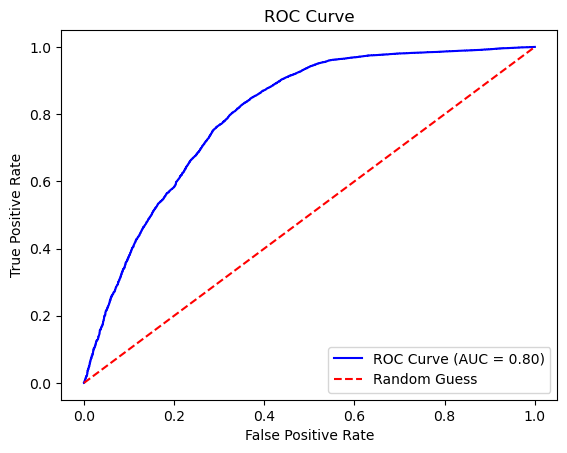

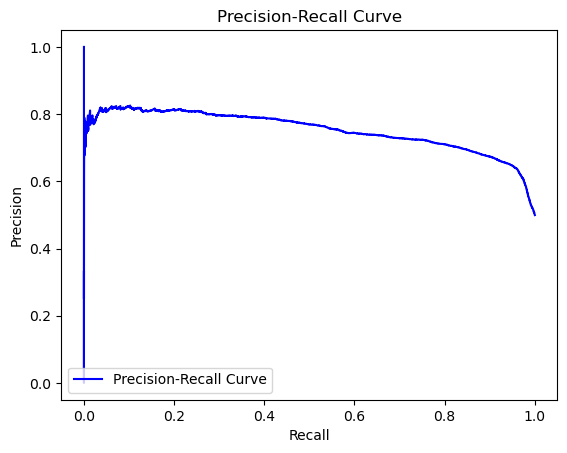

In [70]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

## Step 10: Feature Importance and Explainable AI (XAI)


### Feature Importance
Using Logistic Regression as the baseline model:

C:\Users\Akshay\AppData\Local\Temp\ipykernel_24396\2439646545.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance.head(10), palette='coolwarm')


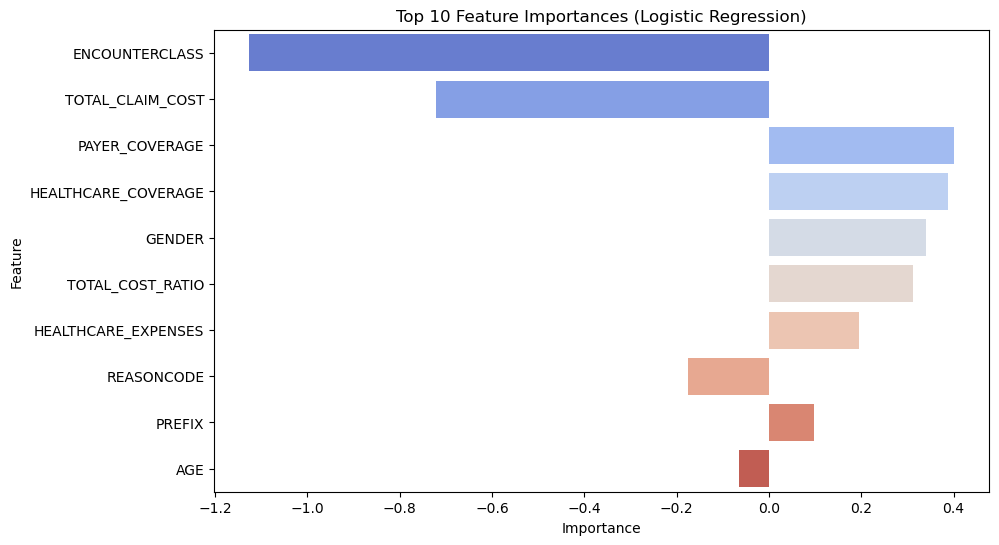

In [71]:
# Extract feature importance (coefficients)
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': baseline_model.coef_[0]
})

# Sort by absolute importance
importance['Absolute Importance'] = importance['Importance'].abs()
importance = importance.sort_values(by='Absolute Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance.head(10), palette='coolwarm')
plt.title('Top 10 Feature Importances (Logistic Regression)')
plt.show()

### Explainable AI with SHAP
Summary Plot and Force Plot

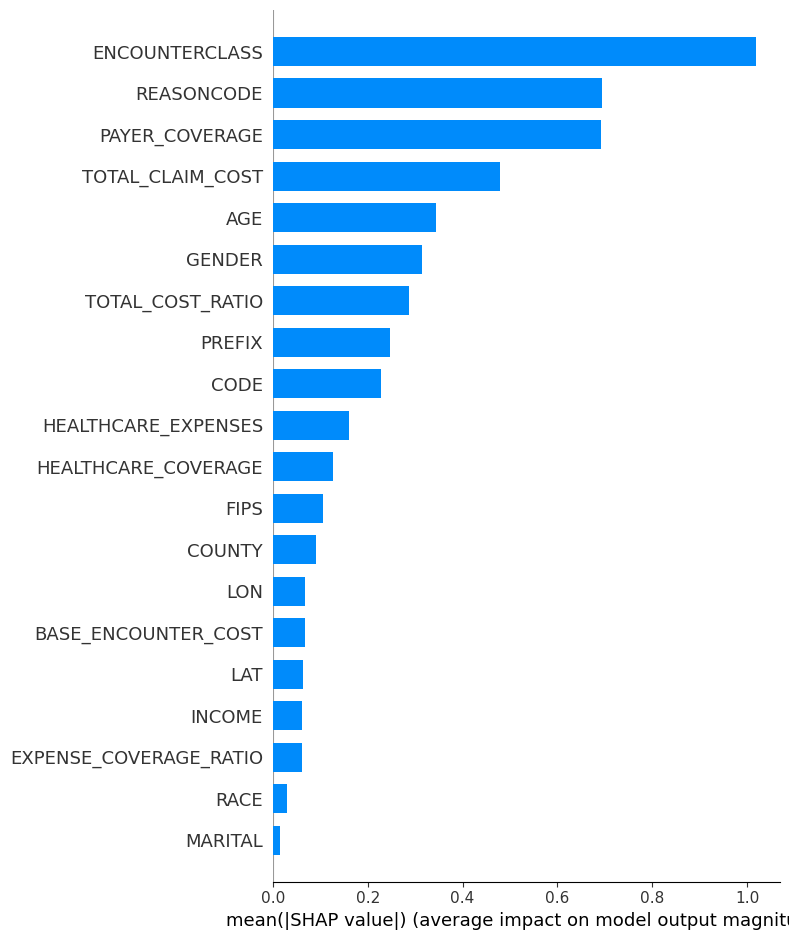

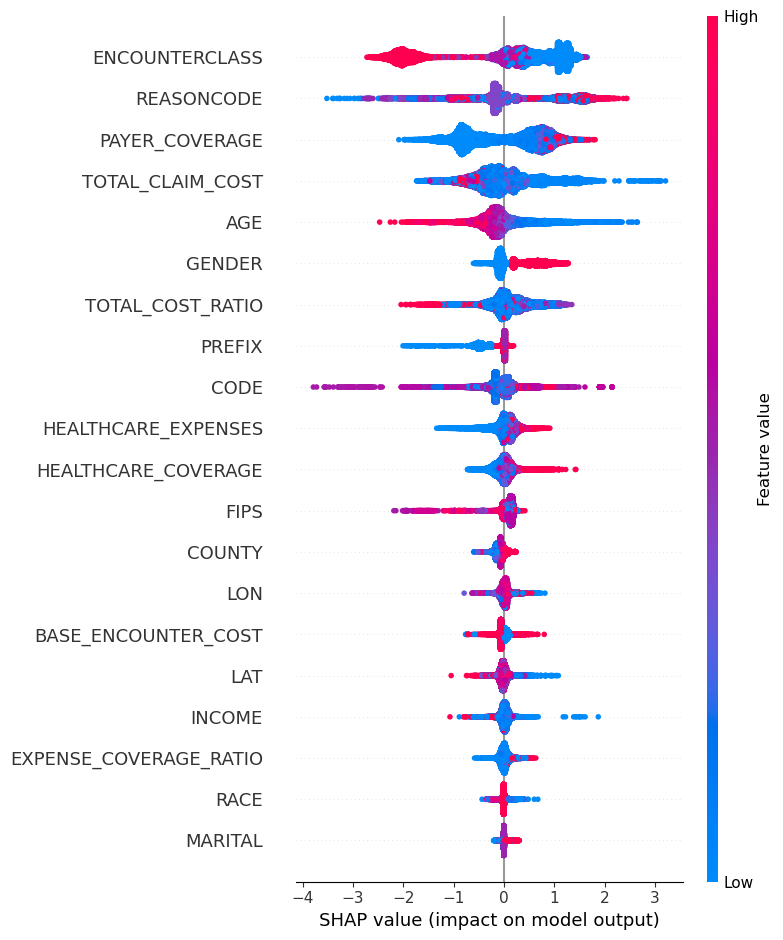

In [120]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Global Explanation: SHAP Summary Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")  # Importance bar chart
shap.summary_plot(shap_values, X_test)  # Beeswarm plot

# Local explanation: force plot for a single prediction
# Enable the interactive force plot
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_test.iloc[0]
)

## Step 11: Advanced Modeling and Comparison


### 1.Random Forest Implementation

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86     17680
           1       0.86      0.85      0.86     17644

    accuracy                           0.86     35324
   macro avg       0.86      0.86      0.86     35324
weighted avg       0.86      0.86      0.86     35324

Random Forest AUC-ROC Score: 0.9363159069366895


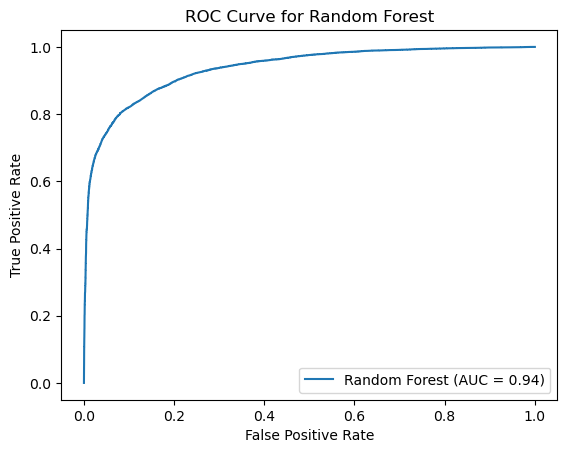

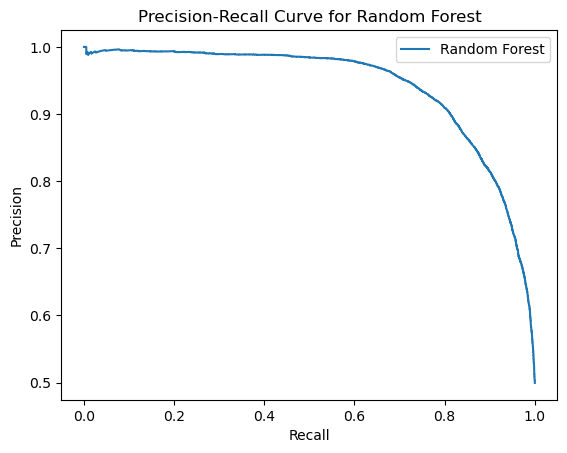

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)

# Train the model
rf_model.fit(X_train, y_train)

# Predictions and probabilities
y_rf_pred = rf_model.predict(X_test)
y_rf_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_rf_pred))
print("Random Forest AUC-ROC Score:", roc_auc_score(y_test, y_rf_proba))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_rf_proba)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_rf_proba):.2f})')
plt.legend()
plt.title("ROC Curve for Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_rf_proba)
plt.plot(recall, precision, label="Random Forest")
plt.title("Precision-Recall Curve for Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

### Feature Importance Analysis

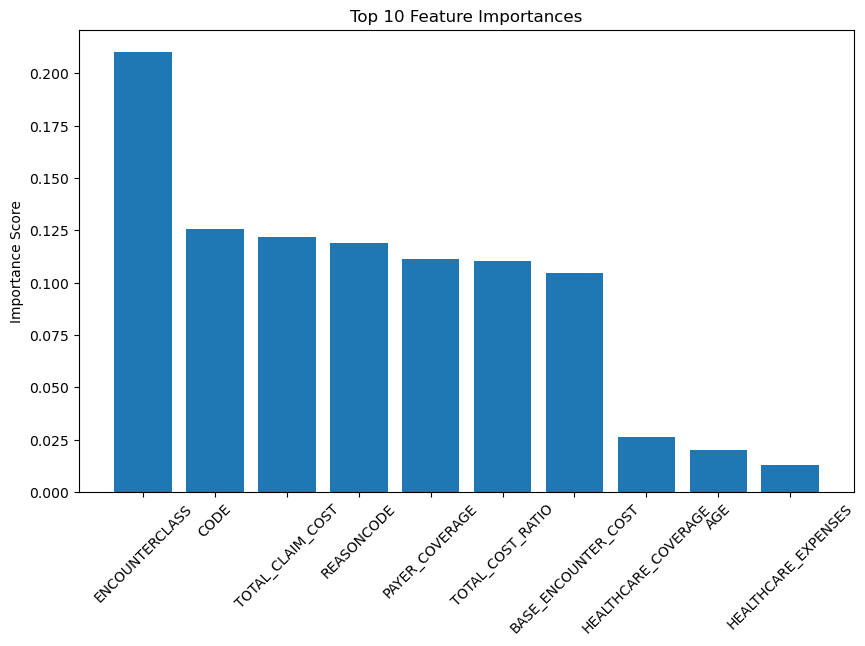

In [89]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), X_train.columns[indices[:10]], rotation=45)
plt.title("Top 10 Feature Importances")
plt.ylabel("Importance Score")
plt.show()


### 2. XGBoost Implementation

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     17680
           1       0.89      0.86      0.87     17644

    accuracy                           0.88     35324
   macro avg       0.88      0.88      0.88     35324
weighted avg       0.88      0.88      0.88     35324

XGBoost AUC-ROC Score: 0.9509911541718514


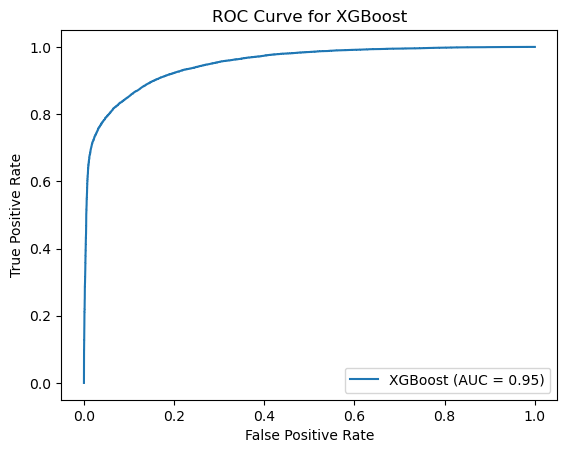

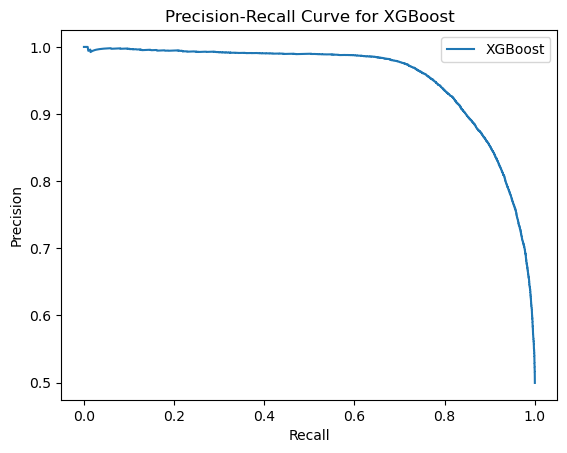

In [91]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve

# Initialize XGBoost without the deprecated parameter
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Train the model
xgb_model.fit(X_train, y_train)


# Predictions and probabilities
y_xgb_pred = xgb_model.predict(X_test)
y_xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("XGBoost Classification Report:")
print(classification_report(y_test, y_xgb_pred))
print("XGBoost AUC-ROC Score:", roc_auc_score(y_test, y_xgb_proba))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_xgb_proba)
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_xgb_proba):.2f})')
plt.legend()
plt.title("ROC Curve for XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_xgb_proba)
plt.plot(recall, precision, label="XGBoost")
plt.title("Precision-Recall Curve for XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

### SHAP Analysis for XGBoost

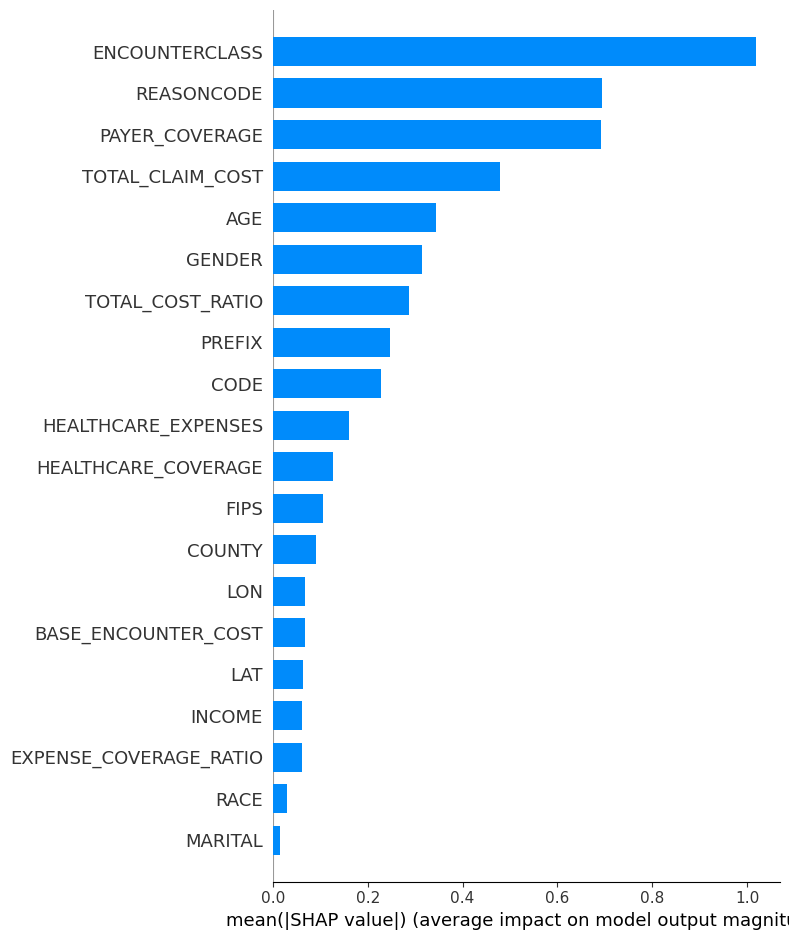

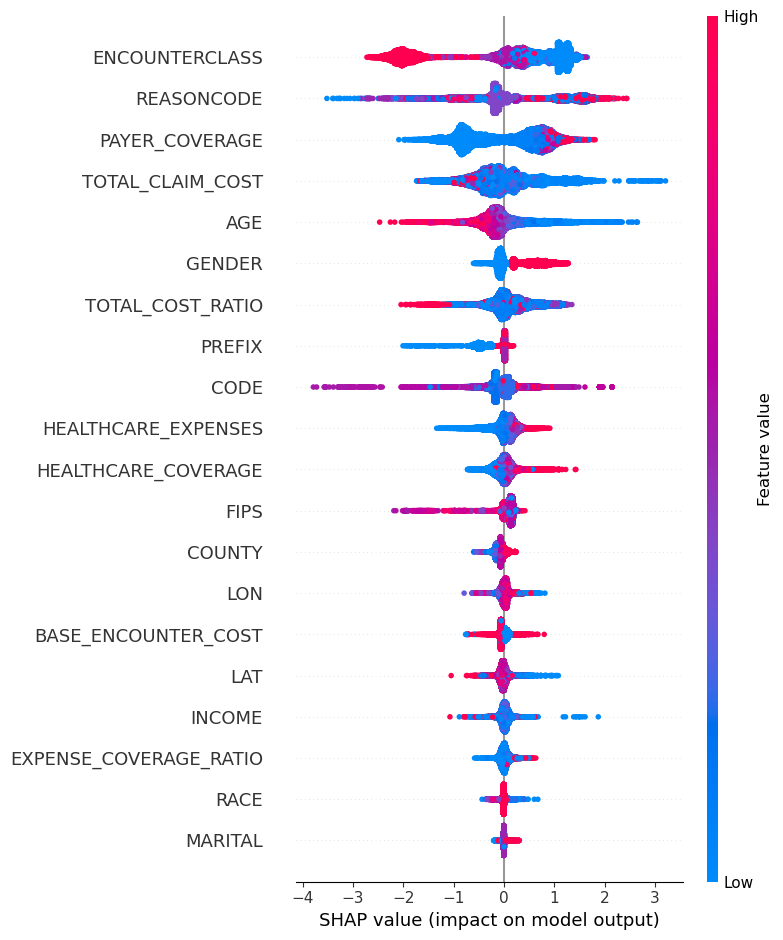

In [97]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Global Explanation: SHAP Summary Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")  # Importance bar chart
shap.summary_plot(shap_values, X_test)  # Beeswarm plot

# Enable the interactive force plot
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_test.iloc[0]
)


## Step 12: Model Comparison and Justification


### Combined AUC-ROC Curve for Model Performance Comparison

The AUC-ROC curve illustrates the performance of the three models:
- **Logistic Regression (AUC = 0.80)** serves as the baseline.
- **Random Forest (AUC = 0.94)** demonstrates significantly better performance, indicating its ability to handle non-linear relationships in the dataset.
- **XGBoost (AUC = 0.95)** slightly outperforms Random Forest, proving its effectiveness in leveraging gradient boosting techniques for improved accuracy.

This visualization confirms that **XGBoost** is the best-performing model for predicting hospital readmission risk.


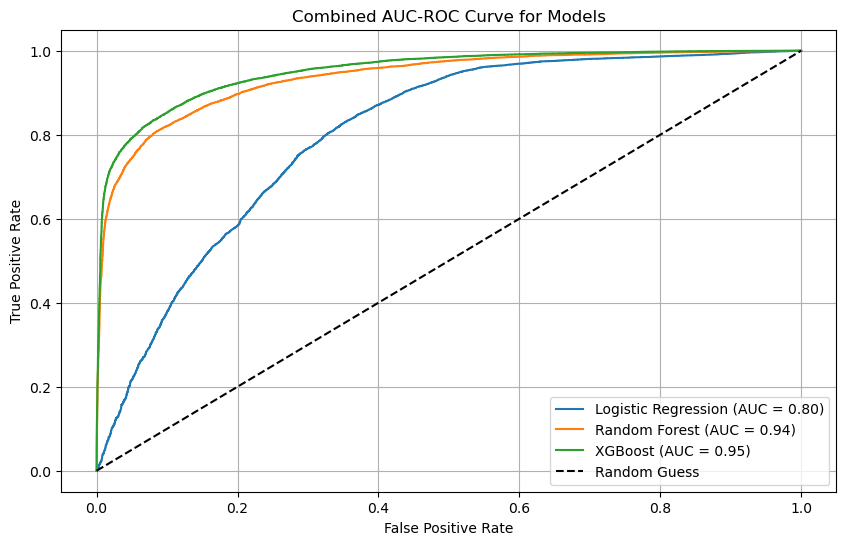

In [99]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Generate probabilities for each model
y_proba_logistic = baseline_model.predict_proba(X_test)[:, 1]
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curves and AUC scores
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_proba_logistic)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

auc_logistic = auc(fpr_logistic, tpr_logistic)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot combined AUC-ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic, tpr_logistic, label=f"Logistic Regression (AUC = {auc_logistic:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})")

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

# Formatting the plot
plt.title("Combined AUC-ROC Curve for Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()